In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Apr 16 11:10:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
pip install SimpleITK

     |████████████████████████████████| 47.4MB 111kB/s 


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [3]:
X_train = np.load('/content/drive/MyDrive/FYP/Lung Segmentation/Numpy Data/X_train_3D_lungSeg.npy')
y_train = np.load('/content/drive/MyDrive/FYP/Lung Segmentation/Numpy Data/y_train_3D_lungSeg.npy')
X_test = np.load('/content/drive/MyDrive/FYP/Lung Segmentation/Numpy Data/X_test_3D_lungSeg.npy')
y_test = np.load('/content/drive/MyDrive/FYP/Lung Segmentation/Numpy Data/y_test_3D_lungSeg.npy')


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((710, 128, 128, 64),
 (710, 128, 128, 64),
 (178, 128, 128, 64),
 (178, 128, 128, 64))

In [ ]:
np.unique(y_train)

array([0, 1], dtype=int16)

In [4]:
X_train = np.expand_dims(X_train, -1)
y_train = np.expand_dims(y_train, -1)
X_test = np.expand_dims(X_test, -1)
y_test = np.expand_dims(y_test, -1)

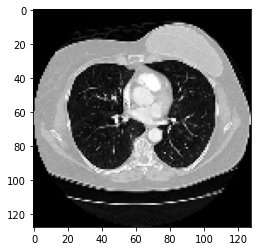

In [5]:
plt.imshow(X_train[30][:,:,30,0],cmap='gray')

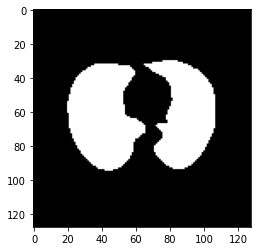

In [16]:
plt.imshow(y_train[30][:,:,30,1],cmap='gray')

In [5]:
y_train = np.concatenate((1 - y_train, y_train), -1)
y_test = np.concatenate((1 - y_test, y_test), -1)

3D U-Net for lung segmentation

In [6]:
from keras.models import *
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam

In [7]:
def build_model(inp_shape, k_size=3):
    merge_axis = -1 # Feature maps are concatenated along last axis (for tf backend)
    data = Input(shape=inp_shape)
    conv1 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(data)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    print('conv1')
    print(conv1.shape)
    conv2 = Convolution3D(padding='same', filters=32, kernel_size=k_size)(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    print('conv2')
    print(conv2.shape)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    print('pool1')
    print(pool1.shape)

    conv3 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    print('conv3')
    print(conv3.shape)
    conv4 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    print('conv4')
    print(conv4.shape)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv4)
    print('pool2')
    print(pool2.shape)

    conv5 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(pool2)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    print('conv5')
    print(conv5.shape)
    conv6 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv5)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    print('conv6')
    print(conv6.shape)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv6)
    print('pool3')
    print(pool3.shape)

    conv7 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    print('conv7')
    print(conv7.shape)
    conv8 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv7)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    print('conv8')
    print(conv8.shape)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conv8)
    print('pool4')
    print(pool4.shape)

    conv9 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(pool4)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    print('conv9')
    print(conv9.shape)

    up1 = UpSampling3D(size=(2, 2, 2))(conv9)
    print('up1')
    print(up1.shape)
    conv10 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(up1)
    conv10 = BatchNormalization()(conv10)
    conv10 = Activation('relu')(conv10)
    print('conv10')
    print(conv10.shape)
    conv11 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(conv10)
    conv11 = BatchNormalization()(conv11)
    conv11 = Activation('relu')(conv11)
    print('conv11')
    print(conv11.shape)
    merged1 = concatenate([conv11, conv8], axis=merge_axis)
    print('merged 1')
    print(merged1.shape)
    conv12 = Convolution3D(padding='same', filters=128, kernel_size=k_size)(merged1)
    conv12 = BatchNormalization()(conv12)
    conv12 = Activation('relu')(conv12)
    print('conv12')
    print(conv12.shape)

    up2 = UpSampling3D(size=(2, 2, 2))(conv12)
    print('up2')
    print(up2.shape)
    conv13 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up2)
    conv13 = BatchNormalization()(conv13)
    conv13 = Activation('relu')(conv13)
    print('conv13')
    print(conv13.shape)
    conv14 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv13)
    conv14 = BatchNormalization()(conv14)
    conv14 = Activation('relu')(conv14)
    print('conv14')
    print(conv14.shape)
    merged2 = concatenate([conv14, conv6], axis=merge_axis)
    print('merged2')
    print(merged2.shape)
    conv15 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged2)
    conv15 = BatchNormalization()(conv15)
    conv15 = Activation('relu')(conv15)
    print('conv15')
    print(conv15.shape)

    up3 = UpSampling3D(size=(2, 2, 2))(conv15)
    print('up3')
    print(up3.shape)
    conv16 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up3)
    conv16 = BatchNormalization()(conv16)
    conv16 = Activation('relu')(conv16)
    print('conv16')
    print(conv16.shape)
    conv17 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv16)
    conv17 = BatchNormalization()(conv17)
    conv17 = Activation('relu')(conv17)
    print('conv17')
    print(conv17.shape)
    merged3 = concatenate([conv17, conv4], axis=merge_axis)
    print('merged3')
    print(merged3.shape)
    conv18 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged3)
    conv18 = BatchNormalization()(conv18)
    conv18 = Activation('relu')(conv18)
    print('conv18')
    print(conv18.shape)

    up4 = UpSampling3D(size=(2, 2, 2))(conv18)
    print('up4')
    print(up4.shape)
    conv19 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(up4)
    conv19 = BatchNormalization()(conv19)
    conv19 = Activation('relu')(conv19)
    print('conv19')
    print(conv19.shape)
    conv20 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(conv19)
    conv20 = BatchNormalization()(conv20)
    conv20 = Activation('relu')(conv20)
    print('conv20')
    print(conv20.shape)
    merged4 = concatenate([conv20, conv2], axis=merge_axis)
    print('merged4')
    print(merged4.shape)
    conv21 = Convolution3D(padding='same', filters=64, kernel_size=k_size)(merged4)
    conv21 = BatchNormalization()(conv21)
    conv21 = Activation('relu')(conv21)
    print('conv21')
    print(conv21.shape)

    conv22 = Convolution3D(padding='same', filters=2, kernel_size=k_size)(conv21)
    output = Reshape([-1, 2])(conv22)
    output = Activation('softmax')(output)
    output = Reshape(inp_shape[:-1] + (2,))(output)
    print('conv22')
    print(conv22.shape)
    print('output')
    print(output.shape)

    model = Model(data, output)
    return model

In [ ]:
inp_shape = (128,128,64,1)
model = build_model(inp_shape)

In [ ]:
def IoU(y_true, y_pred):
   # assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    #assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

In [8]:
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [ ]:
inp_shape = (128,128,64,1)
model = build_model(inp_shape)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer_ = ModelCheckpoint("3D_CT_Lung Segmentation.h5", monitor='val_loss',save_best_only=True)
#model.summary()

In [ ]:

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((710, 128, 128, 64, 1),
 (710, 128, 128, 64, 2),
 (178, 128, 128, 64, 1),
 (178, 128, 128, 64, 2))

In [20]:
with tf.device('/device:GPU:0'):

  hist = model.fit(
            X_train,
            y_train,
            batch_size=3,
            epochs=50,
            shuffle=False,
            verbose=2,
            validation_split = 0.2,
            callbacks = [checkpointer_],
  )

Epoch 1/50
190/190 - 300s - loss: 0.0447 - accuracy: 0.9868 - val_loss: 3.2891 - val_accuracy: 0.5210
Epoch 2/50
190/190 - 282s - loss: 0.0277 - accuracy: 0.9935 - val_loss: 1.3005 - val_accuracy: 0.7789
Epoch 3/50
190/190 - 282s - loss: 0.0252 - accuracy: 0.9942 - val_loss: 0.2940 - val_accuracy: 0.9368
Epoch 4/50
190/190 - 282s - loss: 0.0258 - accuracy: 0.9939 - val_loss: 0.1029 - val_accuracy: 0.9757
Epoch 5/50
190/190 - 282s - loss: 0.0239 - accuracy: 0.9945 - val_loss: 0.1517 - val_accuracy: 0.9704
Epoch 6/50
190/190 - 282s - loss: 0.0246 - accuracy: 0.9942 - val_loss: 0.0468 - val_accuracy: 0.9863
Epoch 7/50
190/190 - 282s - loss: 0.0243 - accuracy: 0.9943 - val_loss: 0.1112 - val_accuracy: 0.9707
Epoch 8/50
190/190 - 282s - loss: 0.0238 - accuracy: 0.9945 - val_loss: 0.0454 - val_accuracy: 0.9870
Epoch 9/50
190/190 - 282s - loss: 0.0232 - accuracy: 0.9947 - val_loss: 0.0324 - val_accuracy: 0.9906
Epoch 10/50
190/190 - 282s - loss: 0.0230 - accuracy: 0.9947 - val_loss: 0.1006 - 

In [21]:
model.load_weights('/content/3D_CT_Lung Segmentation.h5')
model.evaluate(X_test, y_test, verbose=0,batch_size=1)

[0.010871589183807373, 0.9971292018890381]

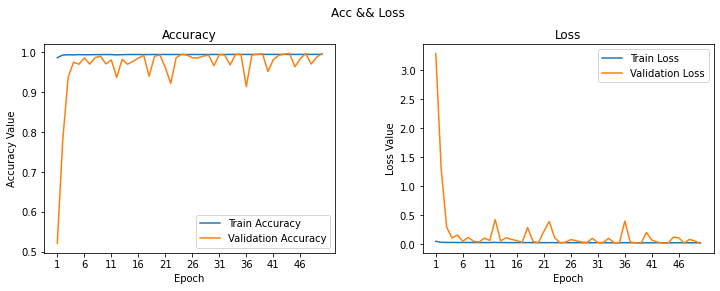

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Acc && Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
np.unique(y_test)

array([0, 1], dtype=int16)

In [10]:
model.load_weights('/content/drive/MyDrive/FYP/Model/ImBalanced Data/3D_CT_Lung Segmentation.h5')

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score,accuracy_score
from sklearn.metrics import classification_report

y_pred1 = model.predict(X_test,batch_size=1)
y_predNew = []

for x in y_pred1:

  predOneDim = x[:,:,:,1]
  predOneDim = np.expand_dims(predOneDim,-1)

  predOneCo = np.where(predOneDim < 0.1,predOneDim,1)
  predOneCo = np.where(predOneCo > 0.1,predOneCo,0)

  y_predNew.append(predOneCo)

In [12]:
y_pred = np.concatenate((1 - np.array(y_predNew), np.array(y_predNew)), -1)

In [13]:
y_pred.shape

(178, 128, 128, 64, 2)

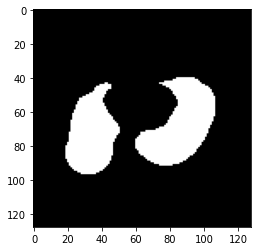

In [16]:
plt.imshow(y_pred[0][:,:,30,1],cmap='gray')

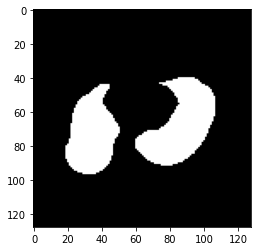

In [21]:
plt.imshow(y_test[0][:,:,30,1],cmap='gray')

In [29]:
def IoU(y_true, y_pred):
   # assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    union = np.logical_or(y_true_f, y_pred_f).sum()
    return (intersection + 1) * 1. / (union + 1)

def Dice(y_true, y_pred):
    #assert y_true.dtype == bool and y_pred.dtype == bool
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.logical_and(y_true_f, y_pred_f).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

In [30]:
y_test.shape,y_pred.shape

((178, 128, 128, 64, 2), (178, 128, 128, 64, 2))

In [33]:
print(IoU(y_test,y_pred))

0.991852834245591


In [40]:
ious = []
dices = []
a = 0
for i in range(178):
  ious.append(IoU(y_test[a],y_pred[a]))
  dices.append(Dice(y_test[a],y_pred[a]))
  a = a+1

ious = np.array(ious)
dices = np.array(dices)

print(np.mean(ious))
print(np.mean(dices))


0.9918877263894426
0.9959097570999639


In [42]:
ious.shape,dices.shape

((178,), (178,))

In [ ]:
#print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_predNew))

ValueError: ignored

In [ ]:
loss,accuracy

(0.675115168094635, 0.8741379380226135)

In [ ]:
test = model.predict(X_test,batch_size=1)

In [ ]:
test.shape

(10, 128, 128, 64, 2)

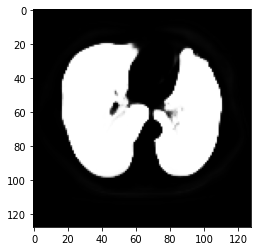

In [ ]:
plt.imshow(test[3][:,:,35,1],cmap='gray')

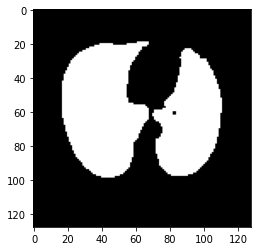

In [ ]:
plt.imshow(y_test[3][:,:,35,1],cmap='gray')

In [ ]:
test1 = np.where(test[3] < 0.5,test[3],1)

In [ ]:
test1.min()

0.5000097

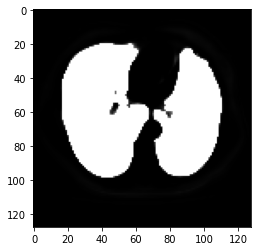

In [ ]:
plt.imshow(test1[:,:,35,1],cmap='gray')

In [ ]:
np.unique(test).size

1037987

In [ ]:
y_te.shape

(100, 128, 128, 64, 2)

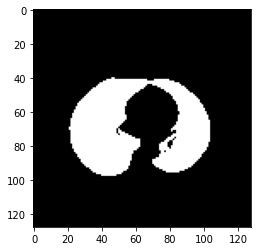

In [ ]:
plt.imshow(y_train[400][:,:,40,1],cmap='gray')

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0,batch_size=1)

In [ ]:
loss, accuracy, f1_score, precision, recall

(0.673360288143158, 1.0, 1.0, 0.5, 0.0)

3D U-NET for lungSeg -> Infectious Area Seg

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [ ]:
X_train = np.load('/content/drive/MyDrive/FYP/LungSeg_InfSeg/X_train_LungSeg_InfSeg.npy')
y_train = np.load('/content/drive/MyDrive/FYP/LungSeg_InfSeg/y_train_LungSeg_InfSeg.npy')
X_test = np.load('/content/drive/MyDrive/FYP/LungSeg_InfSeg/X_test_LungSeg_InfSeg.npy')
y_test = np.load('/content/drive/MyDrive/FYP/LungSeg_InfSeg/y_test_LungSeg_InfSeg.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40, 128, 128, 64, 1),
 (40, 128, 128, 64, 1),
 (10, 128, 128, 64, 1),
 (10, 128, 128, 64, 1))

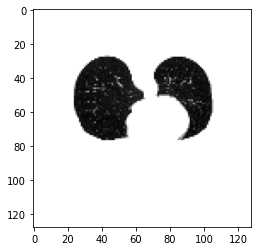

In [ ]:
plt.imshow(X_train[20][:,:,20,0],cmap='gray')

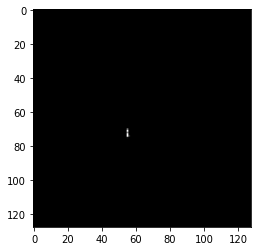

In [ ]:
plt.imshow(y_train[20][:,:,20,0],cmap='gray')

In [ ]:
np.unique(y_train)

array([0.71428573, 0.7142858 , 0.71428585, ..., 0.71499985, 0.7149999 ,
       0.715     ], dtype=float32)

In [ ]:
y_train = np.concatenate((1 - y_train, y_train), -1)
y_test = np.concatenate((1 - y_test, y_test), -1)

y_train.shape,y_test.shape

((40, 128, 128, 64, 2), (10, 128, 128, 64, 2))

In [ ]:
inp_shape = (128,128,64,1)
model = build_model(inp_shape)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.Precision(),keras.metrics.Recall(),keras.metrics.AUC()])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 64 0                                            
__________________________________________________________________________________________________
conv3d_66 (Conv3D)              (None, 128, 128, 64, 896         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 128, 128, 64, 128         conv3d_66[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 128, 128, 64, 0           batch_normalization_63[0][0]     
____________________________________________________________________________________________

In [ ]:
with tf.device('/device:GPU:0'):

  hist = model.fit(
            X_train,
            y_train,
            batch_size=1,
            epochs=10,
            shuffle=False,
            verbose=2,
            validation_data=(X_test,y_test),
  )

Epoch 1/10
40/40 - 68s - loss: 0.6510 - accuracy: 0.9682 - precision_3: 1.0000 - recall_3: 0.5000 - auc_3: 0.0000e+00 - val_loss: 0.7118 - val_accuracy: 0.3408 - val_precision_3: 1.0000 - val_recall_3: 0.5000 - val_auc_3: 0.0000e+00
Epoch 2/10
40/40 - 52s - loss: 0.5989 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 0.5000 - auc_3: 0.0000e+00 - val_loss: 0.6338 - val_accuracy: 0.8657 - val_precision_3: 1.0000 - val_recall_3: 0.5000 - val_auc_3: 0.0000e+00
Epoch 3/10
40/40 - 52s - loss: 0.5986 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 0.5000 - auc_3: 0.0000e+00 - val_loss: 0.6011 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 0.5000 - val_auc_3: 0.0000e+00
Epoch 4/10
40/40 - 52s - loss: 0.5986 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 0.5000 - auc_3: 0.0000e+00 - val_loss: 0.5990 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 0.5000 - val_auc_3: 0.0000e+00
Epoch 5/10
40/40 - 52s - loss: 0.5985 - accuracy: 1.0000 - precision

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0,batch_size=1)

In [ ]:
loss, accuracy, f1_score, precision, recall

(0.5985332727432251, 1.0, 1.0, 0.5, 0.0)

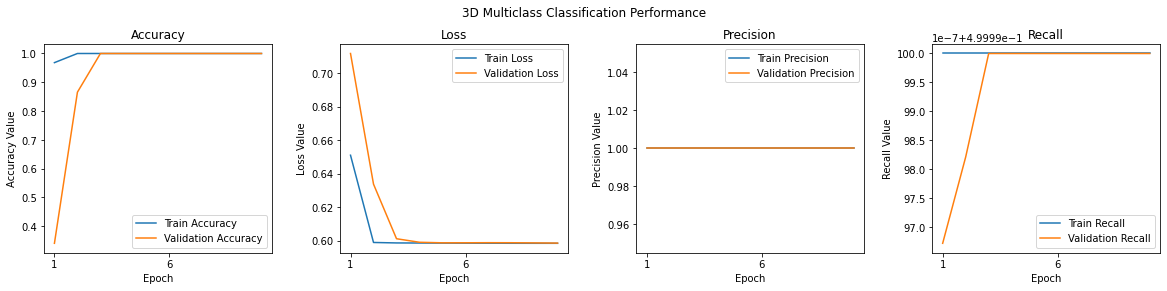

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4),)
t = f.suptitle('3D Multiclass Classification Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(hist.history['accuracy'])+1
epoch_list = list(range(1,max_epoch))

ax1.plot(epoch_list, hist.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, hist.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax2.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

ax3.plot(epoch_list, hist.history['precision_3'], label='Train Precision')
ax3.plot(epoch_list, hist.history['val_precision_3'], label='Validation Precision')
ax3.set_xticks(np.arange(1, max_epoch, 5))
ax3.set_ylabel('Precision Value')
ax3.set_xlabel('Epoch')
ax3.set_title('Precision')
l3 = ax3.legend(loc="best")

ax4.plot(epoch_list, hist.history['recall_3'], label='Train Recall')
ax4.plot(epoch_list, hist.history['val_recall_3'], label='Validation Recall')
ax4.set_xticks(np.arange(1, max_epoch, 5))
ax4.set_ylabel('Recall Value')
ax4.set_xlabel('Epoch')
ax4.set_title('Recall')
l4 = ax4.legend(loc="best")